# Time-series sequences with TinyLlama quantized models

### Introduction

- This action has been completed with the Notebook: https://github.com/labrem/sapheneia/blob/main/notebooks/marcelo/sapheneia_v1.ipynb.
- The following Gemini thread has been used to help build this up both conceptually and in practice: https://g.co/gemini/share/c5212fd78fad.
- This Notebook tests the capabilities of TinyLlama quantized models to generate raw token sequences given an input sequence.
- In order to speed up the model loading, the models have been stored in a local drive.

### Accomplishments

- With this Notebook we are able to achieve the following items.
    - Load and run a local drive instance of the TinyLlama model with different quantization levels (2-bit, 4-bit, 6-bit and 8-bit) on CPU as well as with GPU acceleration.
    - Compute the execution time for each model.
    - Check model behavior with different parameters such as:
    
    ```python
        parameters = {
        'max_tokens': 20, # Maximum number of output generated tokens
        'logprobs': 10, # Number of output token-level log probabilities
        'grammar': grammar, # Valid grammar for output generation
        'temperature': 0.9 # Temperature calibrating the 'surprise of the output generation
    }
    ```
    
    - Define a grammar such that it forces the model to output only certain to tokens such as numbers, period and comma.
    
    ```python
    gbnf_grammar_str = r'''
    root   ::= sequence
    sequence ::= number ("," number)*
    number ::= ("-")? ([0-9]+ | [0-9]+ "." [0-9]+)
    '''
    try:
        grammar = LlamaGrammar.from_string(gbnf_grammar_str)
        print("Strict grammar parsed successfully")
        print(grammar)
    except Exception as e:
        print(f"Error parsing grammar: {e}")
        grammar = None
    ```
    
    - Understand how to output generated token log probabilities. Note how in the log-probabilities for last number in the generated sequence below, where `1`, `2` and `.` appear as the highest probabilities to be sampled by the model. Also note how characters such as `\n` and `:` also show up in the top 10 probabilities, but is never selected in the generative process because it is not compliant with the established grammar.
    
    ```python
    prompt = "1.0,2.1,3.3,4.2,5.7,"
    ...
    ### Running q8_0
    	response = 6.7,7.6,8.9,10.4,12.
    ...
    ... {'1': np.float32(-0.110834435),
    '9': np.float32(-3.750521),
    '2': np.float32(-4.000365),
    '8': np.float32(-4.487987),
    '7': np.float32(-5.1254697),
    '0': np.float32(-5.1982684),
    '\n': np.float32(-5.263313),
    '6': np.float32(-5.366506),
    ' ': np.float32(-5.544479),
    '5': np.float32(-5.6029096)},
    {'2': np.float32(-0.5808073),
    '1': np.float32(-1.1937376),
    '3': np.float32(-2.658832),
    '0': np.float32(-3.187264),
    '4': np.float32(-4.535298),
    '5': np.float32(-5.0283246),
    '.': np.float32(-5.481704),
    '6': np.float32(-6.451225),
    '7': np.float32(-6.923182),
    '8': np.float32(-7.3887563)},
    {'.': np.float32(-0.03789382),
    ',': np.float32(-3.8787103),
    '\n': np.float32(-5.5151057),
    ' ': np.float32(-6.6268954),
    ':': np.float32(-7.178901),
    ')': np.float32(-7.3973727),
    '.,': np.float32(-7.824158),
    ']': np.float32(-7.8326225),
    '-': np.float32(-7.9419684),
    '+': np.float32(-8.018802)}]}
    ```



# setup

* I struggled with the installation witb GPU support, only able to fix from: https://gemini.google.com/app/f3ec74b59f92f56f

* This Gemini thread helpped me setup the dual CPU/GPU support: https://g.co/gemini/share/6c4f43639380

In [41]:
import os
import torch
import time
import numpy as np
import math
from collections import Counter
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # For a nice progress bar

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

path = '/content/drive/MyDrive/dev/'

Mounted at /content/drive/


In [3]:
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

CUDA version: 12.4


In [4]:
if torch.cuda.is_available():
    !nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [5]:
if torch.cuda.is_available():
    !nvidia-smi

Fri Jul 11 14:33:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   44C    P8             16W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
# Uninstall any existing version to ensure a clean slate
print("Uninstalling existing llama-cpp-python to ensure a clean install...")
!pip uninstall -y llama-cpp-python

Uninstalling existing llama-cpp-python to ensure a clean install...


In [7]:
# Check if a CUDA-enabled GPU is available
if torch.cuda.is_available():
    print("GPU detected. Installing the CUDA-enabled version of llama-cpp-python ...")
    # This command will install the version compatible with the Colab GPU's CUDA version
    # The --no-cache-dir flag helps ensure a fresh download
    !pip install llama-cpp-python --extra-index-url https://abetlen.github.io/llama-cpp-python/whl/cu124 --no-cache-dir
else:
    print("No GPU detected. Installing the CPU-only version of llama-cpp-python ...")
    # This is the standard command for a CPU-only installation
    !pip install llama-cpp-python

GPU detected. Installing the CUDA-enabled version of llama-cpp-python ...
Looking in indexes: https://pypi.org/simple, https://abetlen.github.io/llama-cpp-python/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.6/504.6 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.7 MB/s eta 0:00:00


In [8]:
# Verify the installation
try:
    from llama_cpp import Llama, LlamaGrammar
    print("llama-cpp-python imported successfully!")
except Exception as e:
    print(f"Error importing llama-cpp-python: {e}")

llama-cpp-python imported successfully!


# models

## n_gpu_layers

* This Notebook is just to test running various quantized TinyLlama models

* As a result, we will either use either n_gpu_layers = 0 (for running on CPU only) or n_gpu_layers = 33 (33 GPU layers)

* Refer to the Gemini explanation below in order to optimize n_gpu_layers when running the code for getting results

In [9]:
# Check if a CUDA-enabled GPU is available
if torch.cuda.is_available():
    n_gpu_layers = 33 # GPU
else:
    n_gpu_layers = 0 # CPU

https://g.co/gemini/share/1de12d982e5f

That's an excellent and very important question for getting the best performance out of your models. Setting `n_gpu_layers` is the primary way you control the balance between CPU and GPU work.

Here’s a breakdown of what it means and how to find the optimal value for your specific system.

### What `n_gpu_layers` Does

This parameter determines how many layers of the neural network are "offloaded" to your GPU's VRAM.

  * **CPU:** Your computer's main processor. It has access to a large amount of slower system RAM.
  * **GPU:** Your graphics card. It has a smaller amount of very fast video RAM (VRAM) and is designed for the massive parallel calculations that LLMs require.

**The trade-off is simple:**

  * **More layers on the GPU (`n_gpu_layers` is high):** Inference (generating text) is much faster.
  * **Fewer layers on the GPU (`n_gpu_layers` is low):** More work is done on the slower CPU, but it uses less of your precious VRAM.

The "optimal" value is therefore: **The maximum number of layers you can fit into your GPU's VRAM without causing errors, while leaving a small buffer for your operating system.**

-----

### How to Find the Optimal Value: A Practical Guide

The best way to find the perfect number is through a bit of experimentation. Here is a simple, effective process:

#### Step 1: Know Your Total VRAM

First, check how much VRAM your GPU has.

  * **On Windows:** Open the Task Manager, go to the "Performance" tab, and click on your GPU. Look for "Dedicated GPU Memory".
  * **On Linux (with NVIDIA):** Open a terminal and run the command `nvidia-smi`. It will show you your GPU's total memory (e.g., `8192MiB`).

#### Step 2: Start High and Let the Model Tell You

You don't need to guess the number of layers. The easiest method is to set `n_gpu_layers` to a very high number. The `llama-cpp-python` library is smart enough to only offload as many layers as it can actually fit.

Modify your model loading code like this:

```python
from llama_cpp import Llama

llm = Llama(
    model_path="/path/to/your/model.gguf",
    # Set a very high number to offload as many layers as possible
    n_gpu_layers=999,  # <--- START WITH A HIGH NUMBER
    n_ctx=2048,
    verbose=True  # <--- Set to True to see the loading output
)
```

#### Step 3: Observe the Output

When you run this code, `llama.cpp` will print detailed information as it loads the model. Look for a line that looks like this:

```
llama_model_load_internal: offloaded 33 of 33 layers to GPU
```

or

```
llm_load_tensors: offloaded 33/33 layers to GPU
```

**That number is your answer.** In this example, the model has 33 layers, and all of them fit into your VRAM. Your optimal `n_gpu_layers` is **33**. You can then set `n_gpu_layers=33` in your code for future runs to be precise.

#### What If It Crashes?

If you set the number too high manually and your system becomes unstable or the program crashes with a "CUDA out of memory" error, it means you've exceeded your VRAM. In that case, simply lower the number and try again. For example, if `n_gpu_layers=33` crashes, try `30`, then `28`, until you find a stable number.

**Pro Tip:** Often, the last one or two layers of a model can be disproportionately large. If you find that offloading all layers works but your computer feels sluggish, try reducing the number by 1 or 2 (e.g., `n_gpu_layers=31` instead of `33`). This leaves a bit more VRAM for your operating system and can lead to a smoother overall experience with a negligible impact on performance.
That's an excellent and very practical question. Finding the optimal `n_gpu_layers` is the key to getting the best performance out of your hardware. Here’s a breakdown of what it means and how to find the best value for your specific setup.

### What `n_gpu_layers` Does

This parameter controls how many layers of the model are "offloaded" from your system's RAM to the GPU's dedicated, high-speed VRAM.

  * **`n_gpu_layers = 0`**: The entire model runs on your CPU. This is the slowest option but uses the least VRAM.
  * **`n_gpu_layers > 0`**: The specified number of layers are moved to the GPU. Since GPUs are massively parallel, they can process these layers much faster than a CPU, leading to a significant speedup in generating tokens.
  * **The Goal**: Offload as many layers as possible to the GPU without running out of VRAM.

### The Trade-Off: Speed vs. VRAM

The main limiting factor is your GPU's VRAM capacity. Each layer you offload consumes a chunk of VRAM. If you try to offload more layers than your VRAM can hold, the program will crash with an out-of-memory error.

The performance gain is not linear. The bulk of the computation happens in the middle layers. Offloading the first few layers gives a huge speed boost. Continuing to offload more layers gives diminishing returns, but is still faster.

### How to Find the Optimal Value: A Simple Experiment

The best way to find the ideal number is to test it empirically.

**Step 1: Start High**

The easiest way to start is to set `n_gpu_layers` to a very large number, like `-1` or `999`. The `llama-cpp-python` library is smart enough to know this means "offload as many layers as you possibly can".

```python
# Try to offload all layers
llm = Llama(
    model_path="path/to/your/model.gguf",
    n_gpu_layers=-1, # -1 means "all possible layers"
    verbose=True # Set to True to see the loading output
)
```

**Step 2: Watch the Output During Loading**

When the model loads with `verbose=True`, it will print detailed information. Look for a line that looks like this:

`llama_model_load_internal: offloaded 33 of 33 layers to GPU`

This tells you the maximum number of layers the model has (`33` in this case) and how many it successfully moved to the GPU. **The number it successfully offloaded is your practical maximum.**

**Step 3: Monitor Your VRAM**

While the model is loaded, open your system's GPU monitoring tool:

  * **NVIDIA GPUs**: Use `nvidia-smi` in your command line/terminal.
  * **AMD GPUs**: Use `radeontop` or the monitoring utility in your driver software.
  * **Windows**: The Performance tab in the Task Manager (select your GPU).

Check how much VRAM is being used. If it's very close to the maximum (e.g., 7.8GB / 8.0GB), you are at the limit.

**Step 4: Fine-Tune if Necessary**

  * **If it crashes with an "out of memory" error:** Your GPU can't handle all the layers. Reduce the number. If the model has 33 layers, try `n_gpu_layers=28`, then `25`, and so on, until it loads successfully.
  * **If it loads but VRAM is maxed out:** You've found a good value. You might want to reduce it by 1 or 2 layers (`n_gpu_layers=31` instead of `33`) just to leave a little breathing room for your operating system or other applications, which can prevent stuttering.

**In summary, the ideal `n_gpu_layers` is the highest number you can set without running out of VRAM.** The "set it to -1 and see what happens" method is the quickest way to find that number.


## models

https://g.co/gemini/share/5e6bc8594d7d



In [10]:
model_path = path+".models/tinyllama-1.1b-chat-v1.0.Q2_K.gguf"
generator_q2_k = Llama(
    model_path=model_path,
    chat_format="disabled",  # This prevents the model from wrapping input in chat templates
    n_ctx=2048,
    n_threads=2,
    n_gpu_layers=n_gpu_layers,
    logits_all=True,
    verbose=False,
)

llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


In [11]:
# Check the number of layers offloaded to the GPU
offloaded_layers = generator_q2_k.model_params.n_gpu_layers
print(f"✅ Successfully offloaded {offloaded_layers} layers to the GPU")

✅ Successfully offloaded 33 layers to the GPU


In [12]:
model_path = path+".models/tinyllama-1.1b-chat-v1.0.Q4_K_M.gguf"
generator_q4_k_m = Llama(
    model_path=model_path,
    chat_format="disabled",  # This prevents the model from wrapping input in chat templates
    n_ctx=2048,
    n_threads=2,
    n_gpu_layers=n_gpu_layers,
    logits_all=True,
    verbose=False,
)

llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


In [13]:
# Check the number of layers offloaded to the GPU
offloaded_layers = generator_q4_k_m.model_params.n_gpu_layers
print(f"✅ Successfully offloaded {offloaded_layers} layers to the GPU")

✅ Successfully offloaded 33 layers to the GPU


In [14]:
model_path = path+".models/tinyllama-1.1b-chat-v1.0.Q6_K.gguf"
generator_q6_k = Llama(
    model_path=model_path,
    chat_format="disabled",  # This prevents the model from wrapping input in chat templates
    n_ctx=2048,
    n_threads=2,
    n_gpu_layers=n_gpu_layers,
    logits_all=True,
    verbose=False,
)

llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


In [15]:
# Check the number of layers offloaded to the GPU
offloaded_layers = generator_q6_k.model_params.n_gpu_layers
print(f"✅ Successfully offloaded {offloaded_layers} layers to the GPU")

✅ Successfully offloaded 33 layers to the GPU


In [16]:
model_path = path+".models/tinyllama-1.1b-chat-v1.0.Q8_0.gguf"
generator_q8_0 = Llama(
    model_path=model_path,
    chat_format="disabled",  # This prevents the model from wrapping input in chat templates
    n_ctx=2048,
    n_threads=2,
    n_gpu_layers=n_gpu_layers,
    logits_all=True,
    verbose=False,
)

llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


In [17]:
# Check the number of layers offloaded to the GPU
offloaded_layers = generator_q8_0.model_params.n_gpu_layers
print(f"✅ Successfully offloaded {offloaded_layers} layers to the GPU")

✅ Successfully offloaded 33 layers to the GPU


# tests

In [18]:
# Define the grammar in GBNF format
# This grammar allows for a sequence of numbers (integers or decimals) separated by commas
# https://g.co/gemini/share/938d5c086f74
gbnf_grammar_str = r'''
root   ::= sequence
sequence ::= number ("," number)*
number ::= ("-")? ([0-9]+ | [0-9]+ "." [0-9]+)
'''
try:
    grammar = LlamaGrammar.from_string(gbnf_grammar_str)
    print("Strict grammar parsed successfully")
    print(grammar)
except Exception as e:
    print(f"Error parsing grammar: {e}")
    grammar = None

Strict grammar parsed successfully


## testing all quantized models

In [19]:
# Define the prompt with number sequence
prompt = "1.0,2.1,3.3,4.2,5.7,"
#prompt = "1,2,3,4,5,"

In [20]:
# Define parameters for running the model
# https://g.co/gemini/share/5e0aed5cf4b8
# https://g.co/gemini/share/8e15743e2cd6
# https://g.co/gemini/share/1dcee2a72019
parameters = {
    'max_tokens': 20, # Maximum number of output generated tokens
    'logprobs': 1000, # Number of output token-level log probabilities
    'grammar': grammar, # Valid grammar for output generation
    'temperature': 0.9 # Temperature calibrating the 'surprise of the output generation
}

In [22]:
# Dictionary with all generators
generators = {
    'q2_k': generator_q2_k,
    'q4_k_m': generator_q4_k_m,
    'q6_k': generator_q6_k,
    'q8_0': generator_q8_0,
}

In [23]:
# Generate output sequence and logprobs
def time_execution(generator, prompt, params):

    start_time = time.time()
    response = generator(prompt, **params)
    end_time = time.time()
    elapsed_time = end_time - start_time

    choice = response['choices'][0]
    text = choice['text']
    logprobs = choice['logprobs']

    return {'response': text,
            'logprobs': logprobs,
            'elapsed_time': elapsed_time}

In [24]:
# Run results for all models in dict generators
results = {}
r = []
t = []

for key in generators:
    results[key] = {}
    print(f'### Running {key}')
    results[key] = time_execution(generators[key], prompt, parameters)
    s = results[key]['response']
    print(f'\tresponse = {s}')
    s = results[key]['logprobs']
    print(f'\tlogprobs = {s}')
    s = results[key]['elapsed_time']
    print(f'\telapsed_time = {s}')

Output hidden; open in https://colab.research.google.com to view.

In [25]:
results['q8_0']['logprobs']['top_logprobs'][0]

{'6': np.float32(-0.25368243),
 '7': np.float32(-2.4792635),
 '5': np.float32(-3.5000985),
 '1': np.float32(-4.193024),
 '8': np.float32(-4.2830863),
 '4': np.float32(-4.7845225),
 ' ': np.float32(-4.873134),
 '2': np.float32(-5.091663),
 '\n': np.float32(-5.1550307),
 '3': np.float32(-5.209435),
 '9': np.float32(-5.6851115),
 '0': np.float32(-5.975576),
 ' and': np.float32(-6.0301027),
 ' etc': np.float32(-6.917441),
 '<': np.float32(-6.980359),
 'and': np.float32(-7.1213536),
 ' or': np.float32(-7.17541),
 'etc': np.float32(-7.205487),
 '...': np.float32(-7.3786025),
 ' ...': np.float32(-7.724187),
 '  ': np.float32(-7.7778745),
 ' .': np.float32(-7.806314),
 'max': np.float32(-7.841784),
 ' (': np.float32(-7.89041),
 'y': np.float32(-7.902519),
 ' A': np.float32(-8.017706),
 ' <': np.float32(-8.086822),
 'n': np.float32(-8.155408),
 'A': np.float32(-8.206924),
 'x': np.float32(-8.24764),
 'N': np.float32(-8.25274),
 'a': np.float32(-8.272391),
 ' -': np.float32(-8.278733),
 '*': np.

In [26]:
results['q8_0']['response']

'7.2,8.7,10.2,12.2,14'

### save single token log-probabilities

In [34]:
logprobs = results['q8_0']['logprobs']['top_logprobs'][0].copy()

In [32]:
import json

file_path = '/content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/generator_q8_0_logprobs.json'

In [36]:
for key in logprobs:
    logprobs[key] = float(logprobs[key])

with open(file_path, 'w') as json_file:
    json.dump(logprobs, json_file, indent=4)

### save token sequence

In [31]:
response = {}

for key in generators:
    response[key] = results[key]['response']

response

{'q2_k': '10.1,20.2,30.4,40.8,',
 'q4_k_m': '6.8,7.9,8.8,9.8,10.8',
 'q6_k': '7.2,8.8,10.5,12.1,14',
 'q8_0': '7.2,8.7,10.2,12.2,14'}

In [33]:
import json

file_path = '/content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/response_sequences.json'

In [34]:
with open(file_path, 'w') as json_file:
    json.dump(response, json_file, indent=4)

## analysis of single token log-probabilities

In [5]:
# Load sample logprobs for analysis
import json

file_path = '/content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/generator_q8_0_logprobs.json'

logprobs = {}

try:
    with open(file_path, 'r') as json_file:
        logprobs = json.load(json_file)
    print(f"Dictionary loaded from {file_path}:")
    print(logprobs)
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {file_path}.")

Dictionary loaded from /content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/generator_q8_0_logprobs.json:
{'6': -0.272904634475708, '7': -2.412665605545044, '5': -3.4727232456207275, '1': -4.10285758972168, '8': -4.194048881530762, '4': -4.7399492263793945, ' ': -4.851360321044922, '2': -5.01570987701416, '\n': -5.0478715896606445, '3': -5.1466779708862305, '9': -5.572190284729004, ' and': -5.918932914733887, '0': -5.939314842224121, ' etc': -6.749886512756348, '<': -7.024115562438965, 'and': -7.046576499938965, ' or': -7.070944786071777, 'etc': -7.102926254272461, '...': -7.291332244873047, ' ...': -7.644391059875488, '  ': -7.7795610427856445, 'max': -7.819403648376465, ' (': -7.824001312255859, ' .': -7.824521064758301, 'y': -7.828177452087402, ' A': -7.911307334899902, 'n': -8.026654243469238, ' <': -8.069267272949219, 'A': -8.102025032043457, 'a': -8.105005264282227, 'N': -8.14380931854248, ' -': -8.24870777130127, 'x': -8.262267112731934, '*': -8.35293865203857

In [ ]:
import pandas as pd
import numpy as np

In [6]:
logprobs

{'6': -0.272904634475708,
 '7': -2.412665605545044,
 '5': -3.4727232456207275,
 '1': -4.10285758972168,
 '8': -4.194048881530762,
 '4': -4.7399492263793945,
 ' ': -4.851360321044922,
 '2': -5.01570987701416,
 '\n': -5.0478715896606445,
 '3': -5.1466779708862305,
 '9': -5.572190284729004,
 ' and': -5.918932914733887,
 '0': -5.939314842224121,
 ' etc': -6.749886512756348,
 '<': -7.024115562438965,
 'and': -7.046576499938965,
 ' or': -7.070944786071777,
 'etc': -7.102926254272461,
 '...': -7.291332244873047,
 ' ...': -7.644391059875488,
 '  ': -7.7795610427856445,
 'max': -7.819403648376465,
 ' (': -7.824001312255859,
 ' .': -7.824521064758301,
 'y': -7.828177452087402,
 ' A': -7.911307334899902,
 'n': -8.026654243469238,
 ' <': -8.069267272949219,
 'A': -8.102025032043457,
 'a': -8.105005264282227,
 'N': -8.14380931854248,
 ' -': -8.24870777130127,
 'x': -8.262267112731934,
 '*': -8.352938652038574,
 ' &': -8.429669380187988,
 'or': -8.471209526062012,
 'min': -8.573104858398438,
 'in': 

In [29]:
tokens = [',','.','-','0','1','2','3','4','5','6','7','8','9']

In [36]:
distribution = pd.DataFrame(logprobs, index=['logprob']).T.reset_index()
distribution.columns = ['token','logprob']
k = distribution['token'].isin(tokens)
distribution = distribution[k].reset_index(drop=True)
distribution['prob'] = np.exp(distribution['logprob'])
distribution['prob'] = distribution['prob']/distribution['prob'].sum()

In [37]:
distribution

,token,logprob,prob
0,6,-0.272905,0.808812
1,7,-2.412666,0.095183
2,5,-3.472723,0.032975
3,1,-4.102858,0.017560
4,8,-4.194049,0.016029
5,4,-4.739949,0.009286
6,2,-5.015710,0.007048
7,3,-5.146678,0.006183
8,9,-5.572190,0.004040
9,0,-5.939315,0.002799


## get float from token sequence

In [39]:
import json

file_path = '/content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/response_sequences.json'

token_sequences = {}

try:
    with open(file_path, 'r') as json_file:
        token_sequences = json.load(json_file)
    print(f"Dictionary loaded from {file_path}:")
    print(token_sequences)
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {file_path}.")

Dictionary loaded from /content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/response_sequences.json:
{'q2_k': '10.1,20.2,30.4,40.8,', 'q4_k_m': '6.8,7.9,8.8,9.8,10.8', 'q6_k': '7.2,8.8,10.5,12.1,14', 'q8_0': '7.2,8.7,10.2,12.2,14'}


In [43]:
def get_float_from_token_sequence(token_sequences):
    float_sequences = {}

    for key in token_sequences:
        float_sequences[key] = [float(x) for x in token_sequences[key].strip(',').split(',')]

    return float_sequences

In [44]:
float_sequences = get_float_from_token_sequence(token_sequences)
float_sequences

{'q2_k': [10.1, 20.2, 30.4, 40.8],
 'q4_k_m': [6.8, 7.9, 8.8, 9.8, 10.8],
 'q6_k': [7.2, 8.8, 10.5, 12.1, 14.0],
 'q8_0': [7.2, 8.7, 10.2, 12.2, 14.0]}

## simulation

https://g.co/gemini/share/1c98cd1b5e97

In [35]:
prompt = "1.0,2.1,3.3,4.2,5.7,5.0,6.1,5.5,7.0,"

In [36]:
def run_monte_carlo_simulation(prompt, generator, grammar, num_simulations=100, temperature=0.7, max_tokens=10, print_step=50):
    """
    Runs N simulations to generate a distribution of the next predicted number.
    """
    if not grammar or not generator:
        print("Model or grammar not available.")
        return None

    print(f"\n--- Running {num_simulations} simulations with temperature={temperature} ---")

    generated_numbers = []

    for i in range(num_simulations):
        # Print progress every print_step simulations
        if (i + 1) % print_step == 0:
            print(f"  Running simulation {i + 1}/{num_simulations} ...")

        response = generator(
            prompt,
            max_tokens=max_tokens,
            temperature=temperature,
            grammar=grammar,
            stop=["\n", ","] # Stop after the first number is generated
        )

        generated_text = response['choices'][0]['text']

        # Use regex to find the first valid float/integer in the output
        match = re.search(r'-?\d+(\.\d+)?', generated_text)
        if match:
            try:
                # Convert the found number string to a float and add to our list
                num = float(match.group(0))
                generated_numbers.append(num)
            except ValueError:
                continue # Ignore if conversion fails for any reason

    return generated_numbers

In [37]:
simulation_results = run_monte_carlo_simulation(
    prompt=prompt,
    generator=generator_q8_0,
    grammar=grammar,
    num_simulations=2000,
    temperature=0.9
)


--- Running 2000 simulations with temperature=0.9 ---
  Running simulation 50/2000...
  Running simulation 100/2000...
  Running simulation 150/2000...
  Running simulation 200/2000...
  Running simulation 250/2000...
  Running simulation 300/2000...
  Running simulation 350/2000...
  Running simulation 400/2000...
  Running simulation 450/2000...
  Running simulation 500/2000...
  Running simulation 550/2000...
  Running simulation 600/2000...
  Running simulation 650/2000...
  Running simulation 700/2000...
  Running simulation 750/2000...
  Running simulation 800/2000...
  Running simulation 850/2000...
  Running simulation 900/2000...
  Running simulation 950/2000...
  Running simulation 1000/2000...
  Running simulation 1050/2000...
  Running simulation 1100/2000...
  Running simulation 1150/2000...
  Running simulation 1200/2000...
  Running simulation 1250/2000...
  Running simulation 1300/2000...
  Running simulation 1350/2000...
  Running simulation 1400/2000...
  Running sim

In [38]:
if simulation_results:
    # --- Analyze and Display the Distribution ---
    print("\n--- Simulation Results ---")

    # Count the occurrences of each unique number
    number_counts = Counter(simulation_results)

    total_samples = len(simulation_results)

    print(f"Generated {total_samples} valid numbers.")
    print("Top 10 most likely next numbers and their estimated probabilities:")

    # Sort by frequency and display the top 10
    for number, count in number_counts.most_common(10):
        probability = (count / total_samples) * 100
        print(f"  - Number: {number:<10} | Count: {count:<5} | Probability: {probability:.2f}%")


--- Simulation Results ---
Generated 2000 valid numbers.
Top 10 most likely next numbers and their estimated probabilities:
  - Number: 6.5        | Count: 209   | Probability: 10.45%
  - Number: 6.8        | Count: 127   | Probability: 6.35%
  - Number: 6.0        | Count: 120   | Probability: 6.00%
  - Number: 6.3        | Count: 105   | Probability: 5.25%
  - Number: 6.6        | Count: 103   | Probability: 5.15%
  - Number: 7.0        | Count: 99    | Probability: 4.95%
  - Number: 6.7        | Count: 95    | Probability: 4.75%
  - Number: 6.9        | Count: 91    | Probability: 4.55%
  - Number: 7.5        | Count: 89    | Probability: 4.45%
  - Number: 6.2        | Count: 81    | Probability: 4.05%


In [39]:
# Calculate Statistics using NumPy ---
stats = {
    'mean': np.mean(simulation_results),
    'q10': np.quantile(simulation_results, 0.10),
    'q25': np.quantile(simulation_results, 0.25),
    'q50': np.quantile(simulation_results, 0.50), # Median
    'q75': np.quantile(simulation_results, 0.75),
    'q90': np.quantile(simulation_results, 0.90),
}

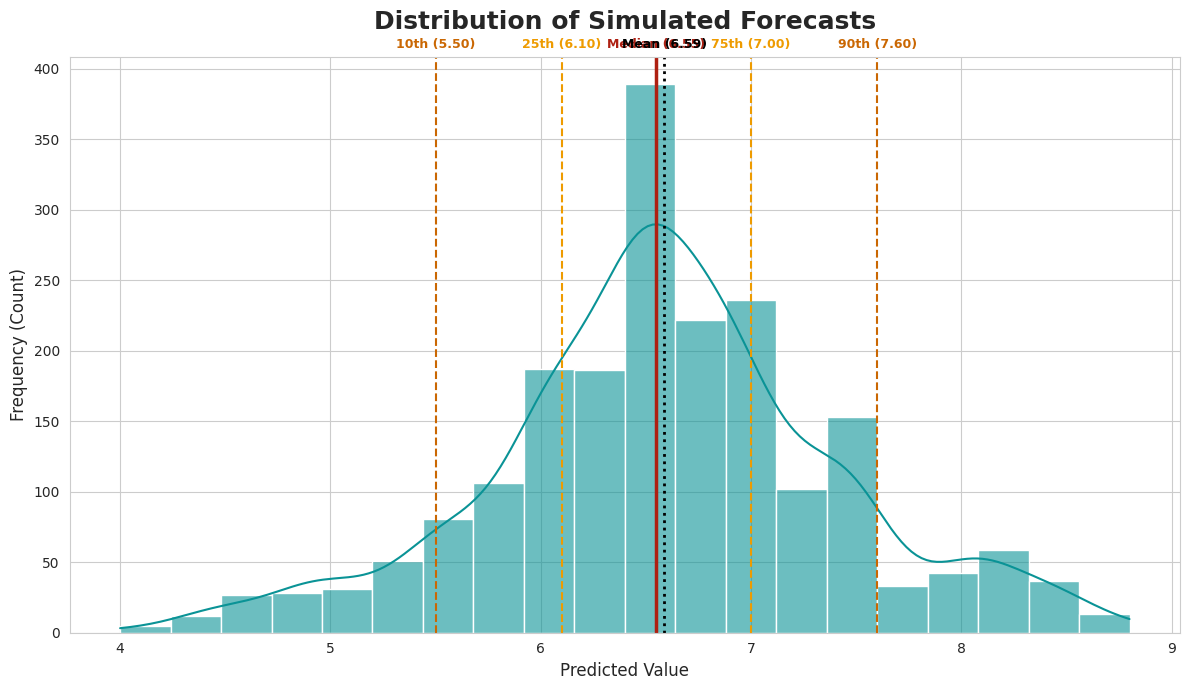


--- Calculated Statistics ---
Mean           : 6.588
Q10            : 5.500
Q25            : 6.100
Q50            : 6.550
Q75            : 7.000
Q90            : 7.600


In [40]:
# Create the Plot ---
# Set a nice style for the plot
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# Create the histogram using seaborn for better aesthetics
# `kde=True` adds a smooth line representing the kernel density estimate
ax = sns.histplot(simulation_results, bins=20, kde=True, color='#0a9396', alpha=0.6)

# Add Vertical Lines and Labels for Stats ---
# Define the lines to draw
lines_to_draw = [
    {'value': stats['q10'], 'label': f"10th ({stats['q10']:.2f})", 'color': '#ca6702', 'style': '--'},
    {'value': stats['q25'], 'label': f"25th ({stats['q25']:.2f})", 'color': '#ee9b00', 'style': '--'},
    {'value': stats['q50'], 'label': f"Median ({stats['q50']:.2f})", 'color': '#ae2012', 'style': '-', 'width': 2.5},
    {'value': stats['mean'], 'label': f"Mean ({stats['mean']:.2f})", 'color': '#000000', 'style': ':', 'width': 2},
    {'value': stats['q75'], 'label': f"75th ({stats['q75']:.2f})", 'color': '#ee9b00', 'style': '--'},
    {'value': stats['q90'], 'label': f"90th ({stats['q90']:.2f})", 'color': '#ca6702', 'style': '--'}
]

# Plot each line
for line in lines_to_draw:
    plt.axvline(
        x=line['value'],
        color=line['color'],
        linestyle=line['style'],
        linewidth=line.get('width', 1.5),
        label=line['label']
    )
    # Add text label slightly above the plot
    plt.text(line['value'], ax.get_ylim()[1] * 1.01, line['label'], color=line['color'], ha='center', va='bottom', fontsize=9, weight='bold')


# --- Final Touches (Labels, Title) ---
plt.title('Distribution of Simulated Forecasts', fontsize=18, weight='bold', pad=20)
plt.xlabel('Predicted Value', fontsize=12)
plt.ylabel('Frequency (Count)', fontsize=12)
plt.legend().set_visible(False) # Hide the default legend as we have text labels
plt.tight_layout()
plt.show()

# --- Print the stats for reference ---
print("\n--- Calculated Statistics ---")
for key, value in stats.items():
    print(f"{key.capitalize():<15}: {value:.3f}")

In [45]:
# Historical data that will be used in the prompt
historical_data = [1.0,2.1,3.3,4.2,5.7,5.0,6.1,5.5,7.0]
prompt = ",".join(map(str, historical_data)) + ","
prompt

'1.0,2.1,3.3,4.2,5.7,5.0,6.1,5.5,7.0,'

In [46]:
def simulate_future_trajectories(
    prompt_text,
    generator_model,
    grammar_obj,
    horizon=20,
    num_simulations=100,
    temperature=0.7
):
    """
    Runs N simulations to generate multiple full future trajectories.
    """
    if not grammar_obj or not generator_model:
        return None

    all_trajectories = []
    print(f"\n--- Running {num_simulations} simulations for a horizon of {horizon} steps ---")

    # Use tqdm for a progress bar
    for _ in tqdm(range(num_simulations), desc="Simulating Trajectories"):
        response = generator_model(
            prompt_text,
            max_tokens=horizon * 5, # Generate enough tokens to get `horizon` numbers
            temperature=temperature,
            grammar=grammar_obj,
            stop=["\n"]
        )

        generated_text = response['choices'][0]['text']

        # Find all numbers in the generated string
        numbers_str = re.findall(r'-?\d+\.\d+|-?\d+', generated_text)

        # Convert to float and take only up to the desired horizon
        trajectory = [float(n) for n in numbers_str[:horizon]]

        # Ensure the trajectory has the correct length by padding if necessary
        while len(trajectory) < horizon:
            trajectory.append(trajectory[-1]) # Simple padding with the last value

        all_trajectories.append(trajectory)

    return np.array(all_trajectories)


In [50]:
# 1. Run the simulation to get the future trajectories
trajectories = simulate_future_trajectories(
    prompt_text=prompt,
    generator_model=generator_q8_0,
    grammar_obj=grammar,
    horizon=10,          # How many steps into the future to predict
    num_simulations=1000, # Number of different futures to generate
    temperature=0.9      # Controls the "width" of the cloud
)


--- Running 1000 simulations for a horizon of 10 steps ---


Simulating Trajectories: 100%|██████████| 1000/1000 [09:43<00:00,  1.71it/s]


In [58]:
def plot_forecast_cloud(historical_data, forecast_trajectories):
    """
    Visualizes historical data and a cloud of forecasted trajectories,
    ensuring the forecast is connected to the historical data.
    """
    # --- Calculate Quantiles ---
    q10 = np.quantile(forecast_trajectories, 0.10, axis=0)
    q25 = np.quantile(forecast_trajectories, 0.25, axis=0)
    q50 = np.quantile(forecast_trajectories, 0.50, axis=0)
    q75 = np.quantile(forecast_trajectories, 0.75, axis=0)
    q90 = np.quantile(forecast_trajectories, 0.90, axis=0)

    # --- THE CRITICAL FIX IS HERE ---
    # Get the last point of the historical data to anchor the forecast
    last_hist_value = historical_data[-1]
    last_hist_time = len(historical_data) - 1

    # Prepend the last historical value to each forecast quantile series
    q10 = np.insert(q10, 0, last_hist_value)
    q25 = np.insert(q25, 0, last_hist_value)
    q50 = np.insert(q50, 0, last_hist_value)
    q75 = np.insert(q75, 0, last_hist_value)
    q90 = np.insert(q90, 0, last_hist_value)

    # Adjust the forecast time axis to start from the last historical point
    forecast_time = np.arange(last_hist_time, last_hist_time + len(q50))
    # --- END OF FIX ---

    # --- Create the Plot ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 8))

    # Define the historical time axis
    historical_time = np.arange(len(historical_data))

    # Plot historical data
    plt.plot(historical_time, historical_data, color='#005f73', label='Historical Data', linewidth=2.5, zorder=3)

    # Plot the median forecast (50th percentile)
    plt.plot(forecast_time, q50, color='#ae2012', linestyle='--', label='Median Forecast (50th)', linewidth=2, zorder=3)

    # Create the "Cloud" using fill_between
    plt.fill_between(forecast_time, q10, q90, color='#ee9b00', alpha=0.2, label='80% Prediction Interval', zorder=1)
    plt.fill_between(forecast_time, q25, q75, color='#ca6702', alpha=0.3, label='50% Prediction Interval', zorder=2)

    # --- Final Touches ---
    plt.title('Probabilistic Time Series Forecast', fontsize=20, weight='bold', pad=20)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

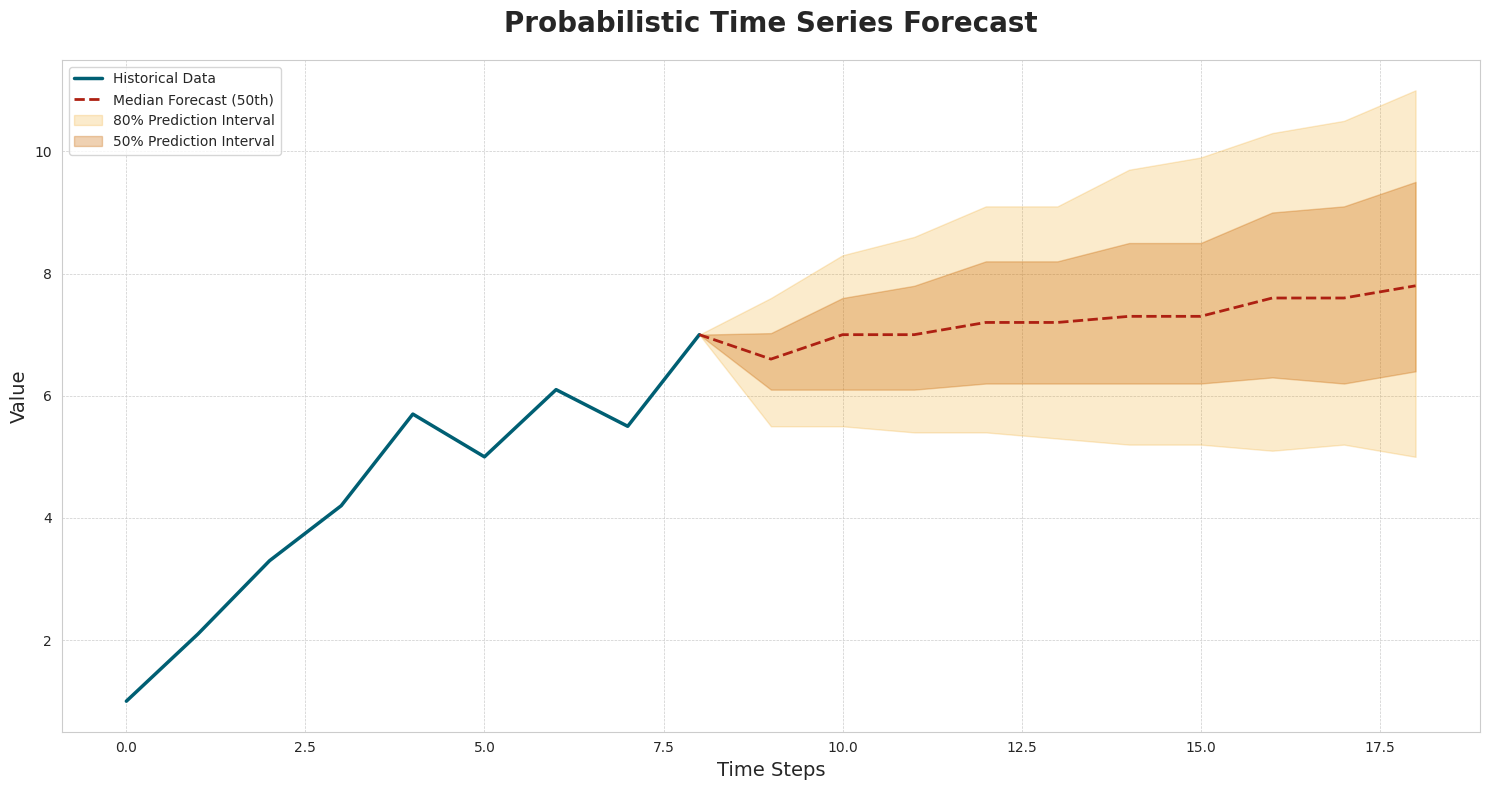

In [59]:
if trajectories is not None:
    plot_forecast_cloud(historical_data, trajectories)

In [55]:
trajectories[100]

array([5.9, 4.1, 5.5, 5.1, 5.1, 4.2, 4.2, 4.9, 4.7, 4. ])

In [56]:
file_path = '/content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/trajectories_simulation.npy'
np.save(file_path,trajectories)

In [57]:
simulated_trajectories = np.load(file_path)
print(simulated_trajectories)

[[6.6 5.8 5.9 ... 3.9 3.9 3.7]
 [7.5 5.  6.2 ... 7.5 8.  5.2]
 [7.  6.1 6.7 ... 6.9 7.5 7.3]
 ...
 [6.5 7.4 6.8 ... 8.5 9.1 8.9]
 [7.2 7.1 7.4 ... 8.3 8.4 7.8]
 [7.  6.1 6.4 ... 4.2 5.  4.5]]
